# How to integrate LangGraph with AutoGen, CrewAI, and other frameworks

LangGraph is a framework for building agentic and multi-agent applications. LangGraph can be easily integrated with other agent frameworks. 

The primary reasons you might want to integrate LangGraph with other agent frameworks:

- create [multi-agent systems](../../concepts/multi_agent) where individual agents are built with different frameworks
- leverage LangGraph to add features like [persistence](../../concepts/persistence), [streaming](../../concepts/streaming), [short and long-term memory](../../concepts/memory) and more

The simplest way to integrate agents from other frameworks is by calling those agents inside a LangGraph [node](../../concepts/low_level/#nodes):

```python
from langgraph.graph import StateGraph, MessagesState, START

autogen_agent = autogen.AssistantAgent(name="assistant", ...)
user_proxy = autogen.UserProxyAgent(name="user_proxy", ...)

def call_autogen_agent(state: MessagesState):
    response = user_proxy.initiate_chat(
        autogen_agent,
        message=state["messages"][-1],
        ...
    )
    ...

graph = (
    StateGraph(MessagesState)
    .add_node(call_autogen_agent)
    .add_edge(START, "call_autogen_agent")
    .compile()
)

graph.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Find numbers between 10 and 30 in fibonacci sequence",
        }
    ]
})
```

In this guide we show how to build a LangGraph chatbot that integrates with AutoGen, but you can follow the same approach with other frameworks.

## Setup

In [1]:
%pip install autogen langgraph

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


## Define AutoGen agent

Here we define our AutoGen agent. Adapted from official tutorial [here](https://github.com/microsoft/autogen/blob/0.2/notebook/agentchat_web_info.ipynb).

In [3]:
import autogen
import os

config_list = [{"model": "gpt-4o", "api_key": os.environ["OPENAI_API_KEY"]}]

llm_config = {
    "timeout": 600,
    "cache_seed": 42,
    "config_list": config_list,
    "temperature": 0,
}

autogen_agent = autogen.AssistantAgent(
    name="assistant",
    llm_config=llm_config,
)

user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "web",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    llm_config=llm_config,
    system_message="Reply TERMINATE if the task has been solved at full satisfaction. Otherwise, reply CONTINUE, or the reason why the task is not solved yet.",
)

---

## Create the graph

We will now create a LangGraph chatbot graph that calls AutoGen agent.

In [4]:
from langchain_core.messages import convert_to_openai_messages
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.checkpoint.memory import MemorySaver


def call_autogen_agent(state: MessagesState):
    # convert to openai-style messages
    messages = convert_to_openai_messages(state["messages"])
    response = user_proxy.initiate_chat(
        autogen_agent,
        message=messages[-1],
        # pass previous message history as context
        carryover=messages[:-1],
    )
    # get the final response from the agent
    content = response.chat_history[-1]["content"]
    return {"messages": {"role": "assistant", "content": content}}


# add short-term memory for storing conversation history
checkpointer = MemorySaver()

builder = StateGraph(MessagesState)
builder.add_node(call_autogen_agent)
builder.add_edge(START, "call_autogen_agent")
graph = builder.compile(checkpointer=checkpointer)

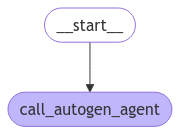

In [5]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Run the graph

We can now run the graph.

In [6]:
# pass the thread ID to persist agent outputs for future interactions
# highlight-next-line
config = {"configurable": {"thread_id": "1"}}

for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Find numbers between 10 and 30 in fibonacci sequence",
            }
        ]
    },
    # highlight-next-line
    config,
):
    print(chunk)

user_proxy (to assistant):

Find numbers between 10 and 30 in fibonacci sequence

--------------------------------------------------------------------------------
assistant (to user_proxy):

To find numbers between 10 and 30 in the Fibonacci sequence, we can generate the Fibonacci sequence and check which numbers fall within this range. Here's a plan:

1. Generate Fibonacci numbers starting from 0.
2. Continue generating until the numbers exceed 30.
3. Collect and print the numbers that are between 10 and 30.

Let's implement this in Python:

```python
# filename: fibonacci_range.py

def fibonacci_sequence():
    a, b = 0, 1
    while a <= 30:
        if 10 <= a <= 30:
            print(a)
        a, b = b, a + b

fibonacci_sequence()
```

This script will print the Fibonacci numbers between 10 and 30. Please execute the code to see the result.

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK 0 (inferred language is python

Since we're leveraging LangGraph's [persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/) features we can now continue the conversation using the same thread ID -- LangGraph will automatically pass previous history to the AutoGen agent:

In [7]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Multiply the last number by 3",
            }
        ]
    },
    # highlight-next-line
    config,
):
    print(chunk)

user_proxy (to assistant):

Multiply the last number by 3
Context: 
Find numbers between 10 and 30 in fibonacci sequence
The Fibonacci numbers between 10 and 30 are 13 and 21. 

These numbers are part of the Fibonacci sequence, which is generated by adding the two preceding numbers to get the next number, starting from 0 and 1. 

The sequence goes: 0, 1, 1, 2, 3, 5, 8, 13, 21, 34, ...

As you can see, 13 and 21 are the only numbers in this sequence that fall between 10 and 30.

TERMINATE

--------------------------------------------------------------------------------
assistant (to user_proxy):

The last number in the Fibonacci sequence between 10 and 30 is 21. Multiplying 21 by 3 gives:

21 * 3 = 63

TERMINATE

--------------------------------------------------------------------------------
{'call_autogen_agent': {'messages': {'role': 'assistant', 'content': 'The last number in the Fibonacci sequence between 10 and 30 is 21. Multiplying 21 by 3 gives:\n\n21 * 3 = 63\n\nTERMINATE'}}}
